**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [389]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
import matplotlib
matplotlib.use('Agg')  # Use 'Agg' backend for non-interactive environments
# plt.ion()  # Turn on interactive mode - not needed with 'Agg'
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [390]:

# Define base models and parameter grids

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Decision Tree
param_grid_dt = {
    'feature_selection__k': [5, 10, 15],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# kNN
param_grid_knn = {
    'feature_selection__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

# Logistic Regression
param_grid_lr = {
    'feature_selection__k': [5, 10, 15],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# List of (classifier, param_grid, name)
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, "Logistic Regression")
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [391]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [392]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [393]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [394]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [395]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Ensure X_train is a pandas DataFrame for consistent indexing
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)

    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # Adjust param grid to not exceed feature count
        adjusted_grid = {}
        for k, vals in param_grid.items():
            if k.endswith('__k'):
                 # Ensure k is not greater than the number of features
                adjusted_grid[k] = [v for v in vals if v is not None and v <= n_features]
                if not adjusted_grid[k]: # If no valid k, skip this classifier or handle appropriately
                     print(f"Warning: No valid 'k' values in parameter grid for {name} with {n_features} features.")
                     # Decide how to handle: skip this classifier, use a default k, etc.
                     # For now, we'll continue and the loop over combinations will be empty if no 'k' values remain.
            else:
                adjusted_grid[k] = vals


        keys, values = zip(*adjusted_grid.items())
        for combo in itertools.product(*values):
            params = dict(zip(keys, combo))
            scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                try:
                    pipe.set_params(**params)
                    pipe.fit(X_tr, y_tr)
                    y_pred_proba = pipe.predict_proba(X_val)[:, 1]
                    scores.append(roc_auc_score(y_val, y_pred_proba))
                except Exception as e:
                    print(f"Error with params {params}: {e}")
                    # Handle errors during fitting or prediction for a specific parameter combination
                    continue # Skip this combination


            if scores: # Only calculate avg_score if scores were recorded
                avg_score = np.mean(scores)

                if avg_score > best_score:
                    best_score = avg_score
                    best_params = params
            else:
                print(f"Warning: No scores recorded for any fold with params {params}. Skipping this combination.")


        print("-" * 90)
        if best_params is not None:
            print(f"Best parameters for {name}: {best_params}")
            print(f"Best cross-validation AUC: {best_score:.4f}")

            final_pipeline = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif)),
                ('classifier', classifier_instance)
            ])
            final_pipeline.set_params(**best_params)
            final_pipeline.fit(X_train, y_train)

            best_estimators[name] = final_pipeline
        else:
            print(f"Could not find best parameters for {name}.")


    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [396]:

def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        adjusted_grid = {k: [v for v in vals if not (k.endswith('__k') and v > n_features)]
                         for k, vals in param_grid.items()}

        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin


## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [397]:
# Add this at the very top of your notebook
%matplotlib inline
import matplotlib.pyplot as plt

def evaluate_models(X_train, y_train, X_test, y_test, best_estimators, dataset_name, method_name):
    print(f"\n==== {dataset_name} - {method_name} Voting ====\n")

    # Voting Classifier (built-in)
    voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in best_estimators.items()],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    # Predictions
    y_pred_votes = voting_clf.predict(X_test)
    y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Evaluate each classifier
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)

        print(f"{name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, "
              f"F1={f1:.4f}, AUC={auc:.4f}")

    # Voting results
    acc = accuracy_score(y_test, y_pred_votes)
    prec = precision_score(y_test, y_pred_votes, zero_division=0)
    rec = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"\nVotingClassifier ({method_name}): "
          f"Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, "
          f"F1={f1:.4f}, AUC={auc:.4f}")

   # ROC Curves
    fig, ax = plt.subplots(figsize=(8, 6))
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        ax.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_avg)
    ax.plot(fpr, tpr, label=f"Voting ({method_name}, AUC={auc:.3f})", linestyle="--", linewidth=2)

    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - {dataset_name} ({method_name})")
    ax.legend()
    ax.grid(True)
    plt.show()   # <-- Force display in Colab

  # Confusion Matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(f"Confusion Matrix - {dataset_name} ({method_name})")
    plt.show()   # <-- Force display in Colab

    return y_pred_votes, y_pred_proba_avg



==== Demo Dataset - Built-in Voting ====

DecisionTree: Acc=0.8967, Prec=0.9237, Rec=0.8521, F1=0.8864, AUC=0.9471
kNN: Acc=0.9067, Prec=0.9385, Rec=0.8592, F1=0.8971, AUC=0.9708
LogisticRegression: Acc=0.8233, Prec=0.8296, Rec=0.7887, F1=0.8087, AUC=0.9128

VotingClassifier (Built-in): Acc=0.9367, Prec=0.9362, Rec=0.9296, F1=0.9329, AUC=0.9795


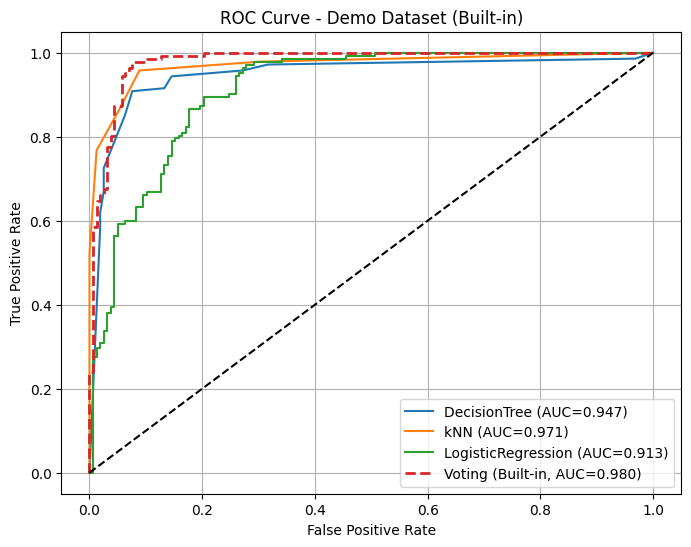

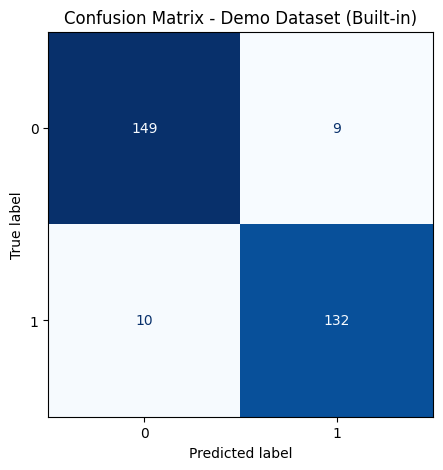

In [398]:
y_pred_votes, y_pred_proba_avg = evaluate_models(
    X_train, y_train, X_test, y_test, best_estimators,
    dataset_name="Demo Dataset", method_name="Built-in"
)

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [399]:
def train_and_tune_models(X_train, y_train):
    best_estimators = {}

    # Decision Tree
    dt_params = {"max_depth": [3, 5, 7, None]}
    dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring="accuracy")
    dt.fit(X_train, y_train)
    best_estimators["DecisionTree"] = dt.best_estimator_

    # kNN
    knn_params = {"n_neighbors": [3, 5, 7, 9]}
    knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring="accuracy")
    knn.fit(X_train, y_train)
    best_estimators["kNN"] = knn.best_estimator_

    # Logistic Regression
    log_params = {"C": [0.01, 0.1, 1, 10]}
    log_reg = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=5, scoring="accuracy")
    log_reg.fit(X_train, y_train)
    best_estimators["LogisticRegression"] = log_reg.best_estimator_

    print("\nBest parameters found:")
    for name, model in best_estimators.items():
        print(f"{name}: {model}")

    return best_estimators

def run_complete_pipeline(dataset_loader, dataset_name):
    print(f"\n{'='*80}")
    print(f"RUNNING PIPELINE FOR {dataset_name.upper()}")
    print(f"{'='*80}")

    # Load dataset (unpack only first 4 values, ignore extras)
    data = dataset_loader()
    X_train, X_test, y_train, y_test = data[:4]

    # Train and tune models
    best_estimators = train_and_tune_models(X_train, y_train)

    # Evaluate and plot
    evaluate_models(
        X_train, y_train, X_test, y_test, best_estimators,
        dataset_name=dataset_name, method_name="Built-in"
    )

    return best_estimators


## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




RUNNING PIPELINE FOR WINE QUALITY
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)

Best parameters found:
DecisionTree: DecisionTreeClassifier()
kNN: KNeighborsClassifier(n_neighbors=3)
LogisticRegression: LogisticRegression(C=1, max_iter=1000)

==== Wine Quality - Built-in Voting ====

DecisionTree: Acc=0.7708, Prec=0.7838, Rec=0.7899, F1=0.7868, AUC=0.7694
kNN: Acc=0.6667, Prec=0.7082, Rec=0.6420, F1=0.6735, AUC=0.7107
LogisticRegression: Acc=0.7375, Prec=0.7652, Rec=0.7354, F1=0.7500, AUC=0.8245

VotingClassifier (Built-in): Acc=0.7667, Prec=0.7866, Rec=0.7743, F1=0.7804, AUC=0.8382


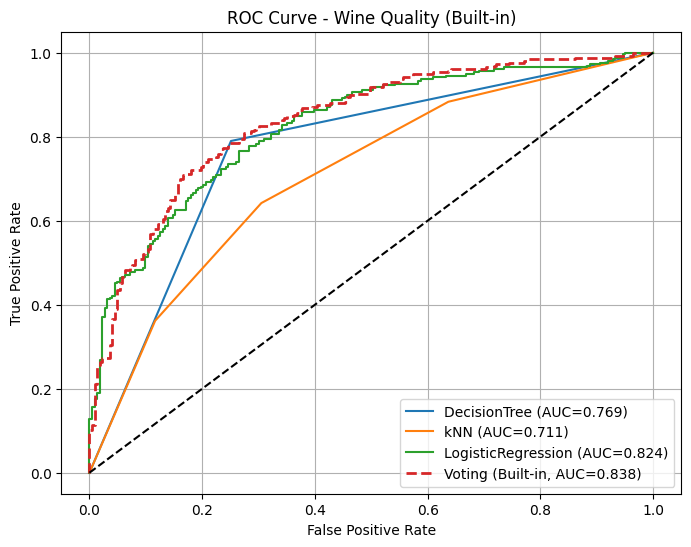

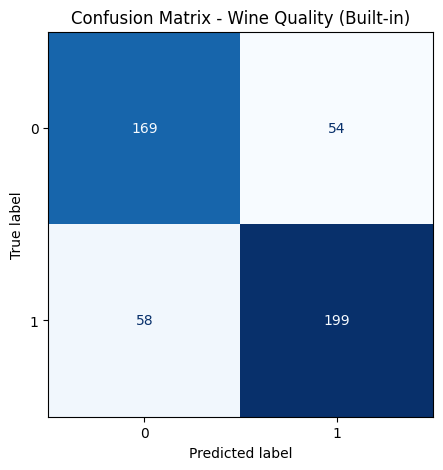


RUNNING PIPELINE FOR HR ATTRITION
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)

Best parameters found:
DecisionTree: DecisionTreeClassifier(max_depth=3)
kNN: KNeighborsClassifier(n_neighbors=9)
LogisticRegression: LogisticRegression(C=1, max_iter=1000)

==== HR Attrition - Built-in Voting ====

DecisionTree: Acc=0.8390, Prec=0.5000, Rec=0.2254, F1=0.3107, AUC=0.7140
kNN: Acc=0.8367, Prec=0.4000, Rec=0.0282, F1=0.0526, AUC=0.6092
LogisticRegression: Acc=0.8617, Prec=0.8125, Rec=0.1831, F1=0.2989, AUC=0.7465

VotingClassifier (Built-in): Acc=0.8435, Prec=0.5833, Rec=0.0986, F1=0.1687, AUC=0.7697


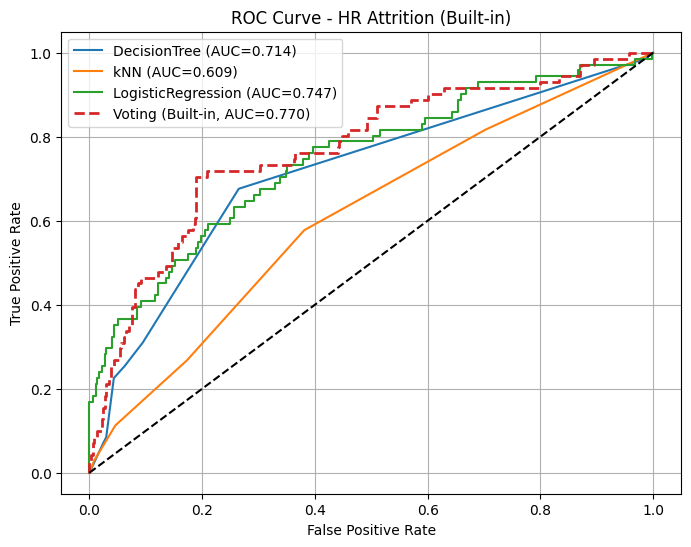

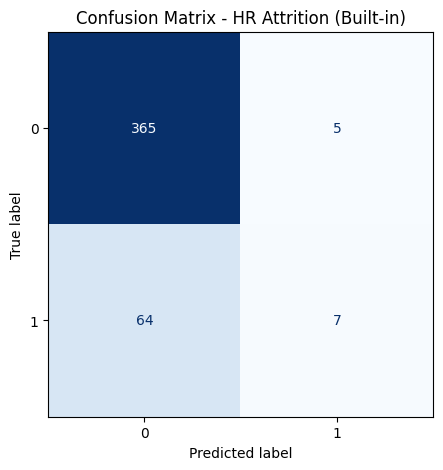


RUNNING PIPELINE FOR BANKNOTE AUTHENTICATION
Banknote Authentication dataset loaded successfully.
Training set shape: (960, 4)
Testing set shape: (412, 4)

Best parameters found:
DecisionTree: DecisionTreeClassifier()
kNN: KNeighborsClassifier(n_neighbors=3)
LogisticRegression: LogisticRegression(C=1, max_iter=1000)

==== Banknote Authentication - Built-in Voting ====

DecisionTree: Acc=0.9854, Prec=0.9733, Rec=0.9945, F1=0.9838, AUC=0.9864
kNN: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000, AUC=1.0000
LogisticRegression: Acc=0.9903, Prec=0.9786, Rec=1.0000, F1=0.9892, AUC=0.9999

VotingClassifier (Built-in): Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000, AUC=1.0000


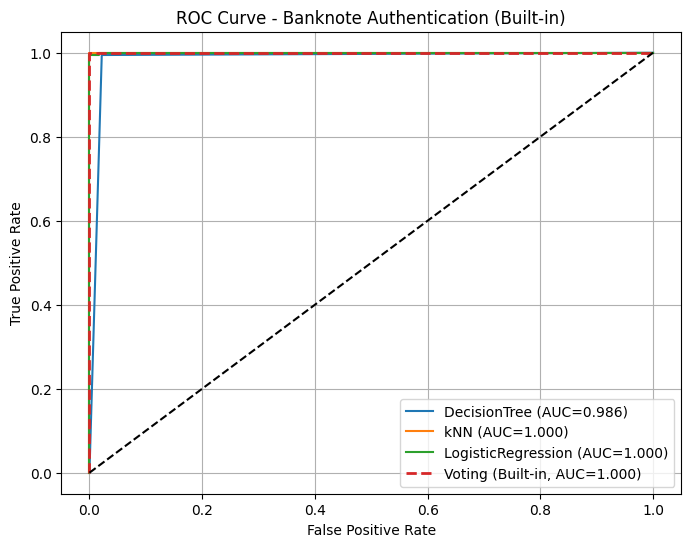

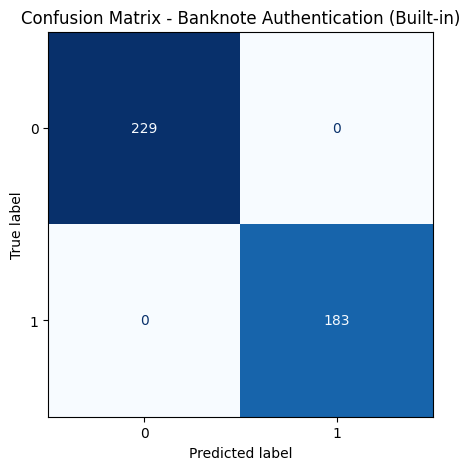


RUNNING PIPELINE FOR QSAR BIODEGRADATION
QSAR Biodegradation dataset loaded successfully.
Training set shape: (738, 41)
Testing set shape: (317, 41)

Best parameters found:
DecisionTree: DecisionTreeClassifier(max_depth=5)
kNN: KNeighborsClassifier()
LogisticRegression: LogisticRegression(C=10, max_iter=1000)

==== QSAR Biodegradation - Built-in Voting ====

DecisionTree: Acc=0.8044, Prec=0.7320, Rec=0.6636, F1=0.6961, AUC=0.8127
kNN: Acc=0.7950, Prec=0.6875, Rec=0.7196, F1=0.7032, AUC=0.8547
LogisticRegression: Acc=0.8612, Prec=0.8247, Rec=0.7477, F1=0.7843, AUC=0.9057

VotingClassifier (Built-in): Acc=0.8549, Prec=0.7905, Rec=0.7757, F1=0.7830, AUC=0.9057


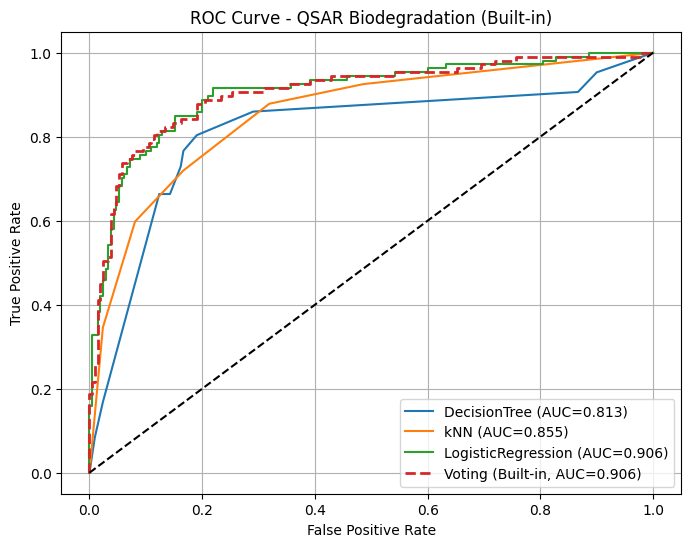

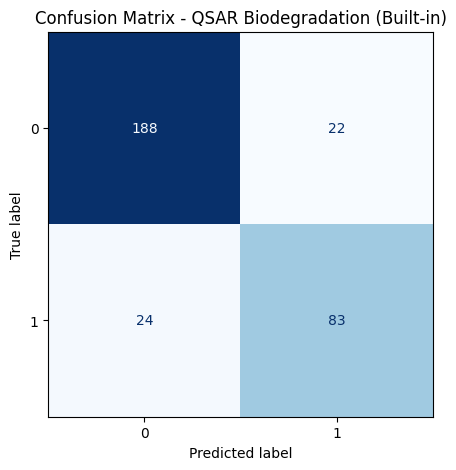


ALL DATASETS PROCESSED!


In [400]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    (load_banknote, "Banknote Authentication"),
    (load_qsar_biodegradation, "QSAR Biodegradation")
]

for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)
